# NLP_GoingDeeper | PROJECT01. 네이버 영화리뷰 감정분석


---
**[ Introduce ]**
- 네이버 영화리뷰 감정 분석 태스크입니다.
- [Exploration 07](https://github.com/babeebird/AIFFEL_Exploration/blob/master/E07_Sentimental_NLP.ipynb) 에서는 KoNLPy Mecab으로 전처리한 후 LSTM, Bidirectional LSTM, GRU, CNN 으로 학습하여 성능을 비교분석하였으며, 추가로 한국어 Word2Vec Pretrained Model+Bidirectional LSTM으로 학습하여 성능개선을 시도했었습니다. 
- 이번에는 **SentencePiece Tokenizer**의 옵션에 따른 성능을 비교해보고자 합니다. 
    - SentencePiece의 데이터 전처리의 정도, model_type, vocab_size 에 따른 성능을 비교분석합니다.
    - 다양한 실험을 위해서 딥러닝 모델은 비교적 가벼운 Bidirectional LSTMa을 사용합니다. 
- 이후에는 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다뤄볼 것입니다.
- 참고 : [Naver sentiment movie corpus v1.0](https://github.com/e9t/nsmc/)

**[ Process ]**

     1. 네이버 영화리뷰 감정 분석 corpus에 SentencePiece를 적용시킨 모델을 학습시킵니다.
     2. 학습된 모델로 sp_tokenize() 메소드를 구현합니다.
     3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습합니다.
     4. KoNLPy 형태소 분석기(Mecab)를 사용한 모델과 성능을 비교합니다. 
     5. SentencePiece 모델의 model_type, vocab_size 등을 변경하면서 성능 개선 여부를 확인합니다. 

**[ Data ]**
- Naver sentiment movie corpus v1.0 은 [네이버 영화](https://movie.naver.com/movie/point/af/list.naver)에서 스크랩한 한국어로 된 영화 리뷰 데이터셋입니다.
- NSMC는 Maas et al., 2011.의 [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/)의 데이터 구조에 기반하여 생성되었습니다. 
- 각 파일은 3개의 컬럼 id, document, label 으로 구성됩니다. 
    - id : The review id, provided by Naver
    - document : The actual review 
    - label : The sentiment class of the review (0: negative, 1:positive)

- Total 200K(총 20만 개) reviews 
    - ratings.txt : All 200K reviews
    - ratings_test.txt : 50K reviews held out for testing
    - **ratings_train.txt : 150K(15만 개) reviews for traing**
- 모든 리뷰는 문장길이 140 이내입니다. (All reviews are shorter than 140 characters)
- 각 sentiment class 는 균등하게 샘플링되었습니다. 
    - 100K negative reviews(originally reviews of ratings 1-4)
    - 100K positive reviews(originally reviews of ratings 9-10)
    - Neutral reviews(originally reviews of ratings 5-8) are excluded


## KoLNPy
- coupus에서 vocab을 만드는 토큰화 기법은 다양합니다. 언어구조의 특성에 맞는 토큰화는 모델의 학습 성능을 좌우하게 됩니다.  
- 한국어의 경우, 가장 기본적인 공백기반 토큰화는 불필요하게 큰 단어사전을 가지게 되어 비효율적인 연산량을 초래할 수 있습니다. 
- 따라서 형태소를 기반으로 토큰화하는 형태소기반 토큰화가 있습니다. 그러나 언어의 가변성으로 인해 정교한 형태소분석기의 성능을 유지하기 위해서는 지속적인 데이터관리와 유지보수 작업이 필요하다는 단점이 있습니다. 

## SentencePiece 
- **SentencePiece모델**은 corpus data로부터 쉽게 추출하여 생성이 가능하며, subword 기반이기 때문에 새롭게 생성되는 단어에 대해 OOV 문제에 robust하게 대처가능하며, 언어 중립적이기 때문에 여러 언어가 섞여 나오는 텍스트를 처리하는 것에도 능합니다. 
- SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer로, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. Sentencepiece의 기본 tokenize 방식은 unigram 입니다. 
- BPE는 발생 빈도수를 이용해서 분할 하였다면 unigram(Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates)은 확률기반으로 subword의 발생확률을 최대화하는 방식으로 분할합니다.
- SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model이 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다. 
    - 최근 Transformer, BERT, ELECTRA 등 대부분의 모델이 Subword 분절 방식을 사용하고 있습니다. 
    - Subword 분절 방식은 OOV(Out-Of-Vocabulary)문제를 해결하고자 고안됐습니다.
    - Subword 분절 방식에는 BPE, SentencePiece, WordPiece 등이 존재합니다. 
        - BPE(Byte Pair Encoding) : 데이터에서 가장 많이 등장하는 바이트 쌍을 새로운 단어로 치환하여 압축하는 작업을 반복하는 방식으로 동작합니다. 
        - WordPiece : Google 에서 BPE를 변형하여 제안한 알고리즘으로, 공백 복원을 위해 단어의 시작 부분에 언더바 _ 를 추가하고, 빈도수 기반이 아닌 가능도(Likelihood)를 증가시키는 방향으로 문자 쌍을 합칩니다. WPM은 아쉽게도 공개되어 있지는 않습니다.
        - SentencePiece : Google 에서는 sentencepiece 라는 이름으로 Word Piece Model package 를 공개하였습니다. 사전 토큰화 작업(pretokenization)없이 전처리를 하지 않은 데이터(raw data)에 바로 단어 분리 토크나이저를 사용할 수 있기에 어떤 언어에도 적용이 가능하다는 강점이 있습니다. 
- 참고 : [Google SentencePiece](https://github.com/google/sentencepiece), [sentencepiece 논문](https://arxiv.org/abs/1808.06226), [Subword Regularization 논문](https://arxiv.org/abs/1804.10959)


## SentencePiece with Morph

- Sentencepiece와 형태소분석기를 함께 사용하는 방법 입니다.
- 형태소분석기를 이용해 문장을 형태소 단위로 분할한 문장으로 변환한 뒤, 형태소 단위로 분할된 문장을 Sentencepiece를 이용해 분할합니다.
- Sentencepiece와 형태소분석기를 함께 사용하는 것이 Sentencepiece만 사용했을 때 보다 성능이 좋다고 알려져 있습니다.

# 1. 데이터 로드

```python
! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
! wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
# ! mkdir -p ~/aiffel/sp_tokenizer/data
! mv ratings_train.txt ~/aiffel/sp_tokenizer/data
! mv ratings_test.txt ~/aiffel/sp_tokenizer/data
! cd ~/aiffel/sp_tokenizer/data
```

#### 코드 살펴보기
- pd.read_table : Read general delimited file into DataFrame.
    - Delimited data is stored as two-dimensional arrays of data, where fields are separated by a delimiter. Any character may be used as a delimiter, but the most common delimiters are the comma, tab and colon.
- pd.iterrows : Iterate over DataFrame rows as (index, Series) pairs.

In [1]:
#- 라이브러리 불러오기
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline

In [2]:
dir_path = os.getenv('HOME')+'/aiffel/GoingDeeper/DATA/sp_tokenizer/data/'

df_train = pd.read_table(dir_path + 'ratings_train.txt') 
df_test = pd.read_table(dir_path + 'ratings_test.txt')

print("TrainData_size:", len(df_train))
print("TestData_size:", len(df_test))

df_train.head()

TrainData_size: 150000
TestData_size: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
#- 리뷰 감정분석에 필요한 document와 label 컬럼만 가져옵니다.
df_train = df_train[['document','label']]
df_test = df_test[['document','label']]

# 2. 데이터 분석
- 결측치(null) 확인
- 중복값 확인
- 문장 길이분포 확인
- 이상치 확인

### 결측치

In [4]:
print(df_train.isnull().sum())
df_train.loc[df_train.document.isnull()]

document    5
label       0
dtype: int64


,document,label
25857,NaN,1
55737,NaN,1
110014,NaN,0
126782,NaN,0
140721,NaN,0


### 중복값
- document와 label이 모두 중복되는 행은 3659개, document만 행은 3817개가 존재합니다.
- 짧은 문장의 경우 중복 가능성이 높음을 추측할 수 있습니다. 
#### 코드 살펴보기
- DataFrame.duplicated : Return boolean Series denoting duplicate rows.

In [5]:
print(df_train.duplicated().sum())
print(df_train.duplicated(subset=['document']).sum())

3659
3817


In [6]:
duplicated = df_train[df_train.duplicated(subset=['document'])]
duplicated['document'].value_counts()

굿                    180
good                  91
최고                    84
쓰레기                   78
별로                    65
                    ... 
ㄱㄱ                     1
재밌어요ㅎㅎ                 1
진짜 안보는게 현명한 판단이다.      1
괜히 봤다                  1
재밋을거같음                 1
Name: document, Length: 1136, dtype: int64

### 길이분포 확인

- 문장의 최단 길이는 1, 최장 길이는 146입니다. 
- Sentence Length Distribution이 매서운 파도의 모양입니다. 

```
    1. 길이가 1인 문장 및 146인 문장을 살펴봅니다. 
    2. 박스플롯에서 눈에 띄는 통계적 이상치를 살펴봅니다.
    3. 문장길이분포에서 어떤부분을 학습에 사용할지 결정합니다. 
```


In [7]:
def sen_distribution(raw):
    '''
    iterable한 원문(raw)을 입력으로 하여, 각 문장(sen)의 길이 분포 그래프(박스플롯, 막대그래프)를 출력합니다.
    최소길이(1)~최대길이 까지의 빈도수를 순차적으로 담고있는 배열(ndarray) sentence_length를 반환합니다.
    '''
    min_len = 999
    max_len = 0 
    sum_len = 0

    for sen in raw:
        length = len(sen) #- length : 문장(sen)의 길이
        if min_len > length : min_len = length 
        if max_len < length : max_len = length 
        sum_len += length 

    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len//len(raw))

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in raw:
        sentence_length[len(sen)-1] += 1

    fig, ax = plt.subplots(1,2, figsize = (10,6))

    #- 박스플롯
    ax[0].boxplot(sentence_length)
    ax[0].set_title('Sentence Length')

    #- 막대그래프
    ax[1].bar(range(max_len), sentence_length, width = 1.0)
    ax[1].set_title("Sentence Length Distribution")

    plt.tight_layout()
    plt.show()
    
    return sentence_length

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


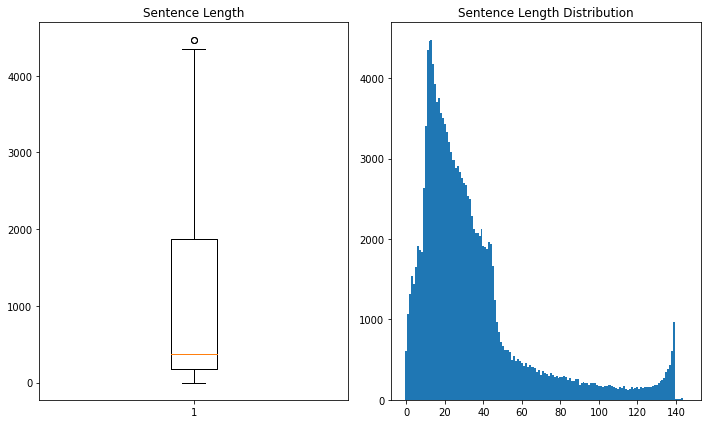

In [8]:
raw = df_train['document'].astype(str) #- review data안에 float타입이 섞여있어서 오류 -> astype(str)으로 타입변환
sentence_length = sen_distribution(raw)

#### boxplot 해석방법
- 박스 플롯은 박스와 박스 바깥의 선(whisker)로 이뤄져 있습니다. 
- whisker는 상자의 좌우 또는 상하로 뻗어나간 선입니다. 
- 박스 내부의 가로선은 중앙값을 나타냅니다. 
- lower whisker는 '중앙값 - 1.5 x IQR' 보다 큰 데이터 중 가장 작은 값입니다. 
- upper whisker는 '중앙값 - 1.5 x IQR' 보다 작은 데이터 중 가장 큰 값입니다. 
- IQR(Inter Quartile Range)은 '제3사분위수 - 제1사분위수'로, Q1과 Q3의 차이값입니다. 
- 박스플롯에서 점은 통계적 이상치(outlier, 특이점)로, lower whisker보다 작은 데이터 또는 upper whisker보다 큰 데이터가 해당됩니다. 

#### 코드 살펴보기
- train_data.loc[[sen],['document']]
    - 배열형태로 열을 입력하면 ['document'] 2차원 데이터프레임이 반환됩니다.
    - 참고 : [loc[]](https://m.blog.naver.com/wideeyed/221964700554)
- [str.isdigit()](https://docs.python.org/3/library/stdtypes.html#str.isdigit)

In [9]:
def check_data_with_length(df, raw, length): 
    
    '''
    raw(원문 리스트)의 요소들을 순차적으로 sen(문장)에 할당하여, 
    문장의 길이가 입력인자로 넣은 length 와 길이가 같을 경우 check_sen 리스트에 추가하고,
    최종적으로 check_data DataFrame을 반환합니다.
    '''
    
    check_data = pd.DataFrame()
    
    for i, sen in enumerate(raw):
        if len(sen) == length:
            check_data = check_data.append(df.loc[i,['document','label']])
            
    return check_data  

In [10]:
check_data_1 = check_data_with_length(df_train, raw, 1) #- 문장길이 1
check_data_1

,document,label
151,아,0.0
384,잼,1.0
584,1,0.0
593,4,0.0
1058,4,0.0
...,...,...
149247,굿,1.0
149718,.,1.0
149862,.,0.0
149919,짱,1.0


In [11]:
check_data_146 = check_data_with_length(df_train, raw, 146) #- 문장길이 146
check_data_146.values.tolist()

[['"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"',
  0.0],
 ['"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"',
  0.0],
 ['"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"',
  1.0]]

- 우리의 목적은 영화 리뷰글의 감정을 분석하는 것입니다. 
- setence_length == 1 인 경우, [굿, 짱, ♥, 잼, ..] 은 한 글자만으로도 긍정적인 감정을 느낄 수 있고, [쉣, 똥, 꽝, 음, ..]은 부정적인 감정이 느껴집니다. 
- sentence_length == 146 인 경우, 정성스런 리뷰를 확인할 수 있습니다. 글 전체에 긍정 또는 부정의 감정이 묻어있습니다. 
- 따라서 단순히 문장이 짧거나 길다고 해서 제거하는 것은 적절하지 않을 수 있습니다.
- 숫자로만 구성된 경우, 감정분석 모델학습에서 얼마나 유의미한지, 노이즈로 작용하지는 않을지 살펴보겠습니다. 

In [12]:
#- 숫자가 하나라도 포함된 데이터 추출
import re
check_any_number = pd.DataFrame()
for i, sen in enumerate(raw):
    if re.sub(r'[^0-9]', '', sen):
        check_any_number = check_any_number.append(df_train.loc[i,['document','label']])
check_any_number

,document,label
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0.0
11,볼때마다 눈물나서 죽겠다90년대의 향수자극!!허진호는 감성절제멜로의 달인이다~,1.0
26,kl2g 고추를 털어버려야 할텐데,1.0
29,센스있는 연출력..탁월한 캐스팅..90년대의 향수.. 그래서 9점..,1.0
33,1%라도 기대했던 내가 죄인입니다 죄인입니다....,0.0
...,...,...
149978,그리 만족스럽진못했어도 7점은 나와야되는것같아 10점줌. 주인공들연기도 훌륭했고 내...,1.0
149986,1점도아깝다진짜 개빡친다 내아까운시간,0.0
149989,아직 척편이여서 그런지 모르겠지만 내용 이해 불가50가지 그림자가 뭔지 모르겠습니다,0.0
149991,http://blog.naver.com/oroblast/220215679580 나쁜...,1.0


In [13]:
#- 숫자로만 이뤄진 데이터 추출 

check_only_number = pd.DataFrame()
for i, sen in enumerate(raw):
    if sen.isdigit():
        check_only_number = check_only_number.append(df_train.loc[i,['document','label']])

check_only_number

,document,label
584,1,0.0
593,4,0.0
1058,4,0.0
2327,1236547890,1.0
2977,1,0.0
8045,1,0.0
12280,10,1.0
12414,1234567891,1.0
13136,10,1.0
14179,1234567890,1.0


In [14]:
#- 테스트 데이터셋에서 숫자로만 이뤄진 데이터 추출

check_only_number_test = pd.DataFrame()
for i, sen in enumerate(df_test['document'].astype(str)):
    if sen.isdigit():
        check_only_number_test = check_only_number_test.append(df_test.loc[i,['document','label']])

check_only_number_test

,document,label
2671,0000000000,0.0
3067,1,0.0
3262,10,1.0
6603,10,1.0
7950,00000,1.0
8557,12345678910,1.0
9481,166626663666,0.0
14026,1122334455,0.0
17066,3,0.0
17817,0311000000000000000000000000000000000000000000...,0.0


In [15]:
check_only_number.shape

(58, 2)

- 숫자가 하나라도 포함된 데이터(check_any_number)에서 숫자는 감정표현에 큰 역할을 하는 것으로 보입니다.
- 숫자로만 구성된 데이터(check_only_number)는 총 58개로 전체 150,000개 중에서 매우 적은 수입니다. 
    - 18이 포함된 경우 라벨이 0인것으로 보아, 한국어 비속어인 신발을 의미하는 것 같습니다.
    - 1~5까지의 숫자가 하나이거나 반복된 경우 라벨이 0이고, 9-10인 경우엔 라벨이 1인것으로 보아, 리뷰평점을 의미하는 것 같습니다. 
    - 하지만 대부분의 경우, 유의미한 패턴을 찾기가 어렵습니다.
- 숫자로만 구성된 데이터는 전체 데이터에서 매우 적은 비중을 차지하기도 하기도 하고, 큰 의미가 드러나지 않아 오히려 노이즈가 될 수 있으며, 평점을 나타내는 숫자는 숫자를 하나 이상 포함한 check_any_number 데이터에서 더 유의미하다고 판단했습니다. 
- 따라서, check_only_number 에 해당하는 '숫자로만 구성된 데이터'는 훈련 데이터셋에서 제거하겠습니다.  

```python
check_not_alnum = pd.DataFrame()
for i, sen in enumerate(raw):
    if not(sen.isalnum()): #- 문자열이 영어, 한글 혹은 숫자로만 되어있는지 확인 후 True, False로 리턴

        check_not_alnum = check_not_alnum.append(df_train.loc[i,['document','label']])

check_not_alnum
```

### 이상치 확인
- 문장길이(sentence_length)가 14인 경우, 지나치게 많은 수의 문장이 존재하여 통계적으로는 이상치를 보이고 있습니다.
- 확인결과, 감정의 긍정/부정이 잘 드러난 유의미한 문장으로 판단되어 제거하지 않겠습니다.

In [16]:
cnt = 0

for idx, _sum in enumerate(sentence_length):
    #- 문장의 수가 가장 많은 문장길이를 추출합니다.
    
    if _sum == max(sentence_length):
        print("Outlier Index:", idx+1)
        cnt += 1
        if cnt > 5 : 
            break

Outlier Index: 14


In [17]:
check_data_14 = check_data_with_length(df_train, raw, 14)
check_data_14

,document,label
74,어설픈 전개 어이없는 결말,0.0
107,크리스마스하면 떠오르는영화,1.0
119,절대 보지마라 쓰레기 영화,0.0
131,베댓이 말을 아주 잘써놨네,1.0
177,정말 아름다운 영화 입니다,1.0
...,...,...
149757,이 감독 개웃김 인정 ㅋㅋ,1.0
149839,일주일이 기다려진다꼭보세요,1.0
149883,짱!!!!♥♥♥♥ 강추강추,1.0
149913,나의기억으로선진짜재미없었다,0.0


## 3. 데이터 전처리 
- SentencePiece와 KoLNPy 형태소분석기의 데이터 전처리에 따른 성능을 비교하기 위해서, 최소한의 전처리된 데이터와 최대한의 전처리된 데이터를 구분하여 저장하겠습니다. 성능 평가를 위해 test 데이터도 train 데이터와 동일한 작업을 해줍니다.


- df_train : 전처리 없음
- min_cleaned_train : 최소한의 전처리
    - 중복값 제거
    - 결측치 제거 
    - check_only_number 제거
- max_cleaned_train : 최대한의 전처리
    - 중복값 제거
    - 결측치 제거 
    - check_only_number 제거
    - 한글과 공백이외에 모두 제거
    - 불용어 제거 
    - 문장길이 제한
        

|항목|원본 데이터|최소 전처리 데이터|최대 전처리 데이터|
|--|--|--|--|
|중복값 제거|x|o|o|
|결측치 제거|x|ㅇ|ㅇ|
|숫자로만 구성 제거|x|o|o|
|한글, 공백이외 모두 제거|x|x|o|
|불용어 제거|x|x|o|
|문장길이 제한|x|x|o|
|train|df_train|min_cleaned_train|max_cleaned_train|
|test|df_test|min_cleaned_test|max_cleaned_test|
|Input_train|train_data,train_label|min_train_data,min_train_label|max_train_data,max_train_label|
|Input_test|train_data,train_label|min_test_data,min_test_label|max_test_data,max_test_label|
|데이터 개수 (train, test)|15만, 5만|14.6만, 4.9만|13.8만, 4.6만|


In [18]:
#- train data preprocessing (min cleaned)
min_cleaned_train = df_train.drop(check_only_number.index) #- check_only_number 제거
min_cleaned_train = min_cleaned_train.dropna(how='any') #- 결측치를 포함한 행 제거
min_cleaned_train.drop_duplicates(subset=['document'], inplace=True) #- 중복값을 포함한 행 제거
min_cleaned_train.reset_index(drop=True, inplace=True) #- 인덱스 재정렬
print(min_cleaned_train.isnull().values.any())
print(min_cleaned_train.shape)
min_cleaned_train

False
(146157, 2)


,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
146152,인간이 문제지.. 소는 뭔죄인가..,0
146153,평점이 너무 낮아서...,1
146154,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
146155,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [19]:
#- test data preprocessing (min cleaned)
min_cleaned_test = df_test.copy()
min_cleaned_test.drop(check_only_number_test.index, inplace=True)
min_cleaned_test.dropna(how='any', inplace=True)
min_cleaned_test.drop_duplicates(subset=['document'], inplace=True)
min_cleaned_test.reset_index(drop=True, inplace=True) 
print(min_cleaned_test.shape)
min_cleaned_test

(49134, 2)


,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...
49129,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49130,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49131,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49132,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [20]:
def threshold_len(min_len, max_len, nested_list): #- length = len(sen)
    '''
    문장의 최대&최소 길이조건을 만족하는
    샘플의 전체샘플에 대한 비율을 출력합니다.
    '''
    cnt = 0
    for sen in nested_list:
        if (len(sen) <= max_len and len(sen) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이상이면서 %s 이하인 샘플의 비율 : %s'%(min_len, max_len, round(cnt / len(nested_list), 4)))

전체 샘플 중 길이가 5 이상이면서 120 이하인 샘플의 비율 : 0.9487
문장의 최단 길이: 5
문장의 최장 길이: 119
문장의 평균 길이: 32


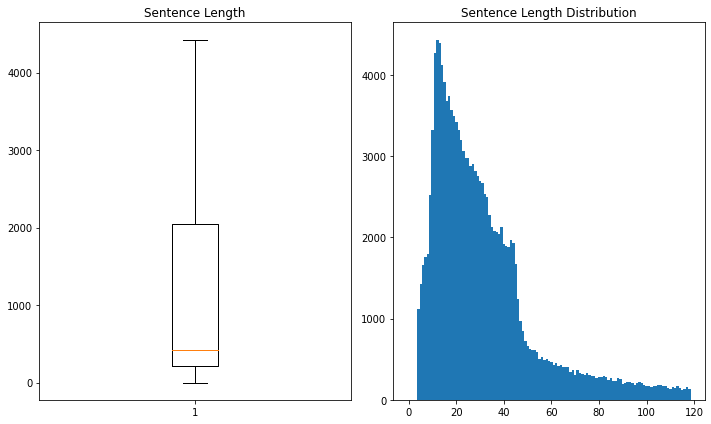

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...
138159,인간이 문제지.. 소는 뭔죄인가..,0
138160,평점이 너무 낮아서...,1
138161,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
138162,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [21]:
#- train data preprocessing (max cleaned)
max_cleaned_train = min_cleaned_train.copy()
max_cleaned_train = max_cleaned_train[max_cleaned_train['document'].str.contains("[ㄱ-ㅎㅏ-ㅣ가-힣 ]")]


min_len = 5; max_len = 120
threshold_len(min_len, max_len, max_cleaned_train.document.astype(str))
max_cleaned_train = max_cleaned_train.iloc[[idx for idx,s in enumerate(max_cleaned_train.document) if (len(s) < max_len) & (len(s) >= min_len)]]
max_cleaned_train.reset_index(drop=True, inplace=True) 
sen_distribution(max_cleaned_train.document)
max_cleaned_train

In [23]:
check_data_5 = check_data_with_length(max_cleaned_train, max_cleaned_train.document, 5)
check_data_5

,document,label
50,재미있어요,1.0
51,전 좋아요,1.0
118,아 빵점~,0.0
267,ㅠㅠ 슬픔,1.0
374,최고의영화,1.0
...,...,...
137340,실로 명품,1.0
137761,성인 호그,1.0
137776,1점대찍자,0.0
137906,적당 ㅎㅎ,1.0


전체 샘플 중 길이가 5 이상이면서 120 이하인 샘플의 비율 : 0.9459
문장의 최단 길이: 5
문장의 최장 길이: 119
문장의 평균 길이: 32


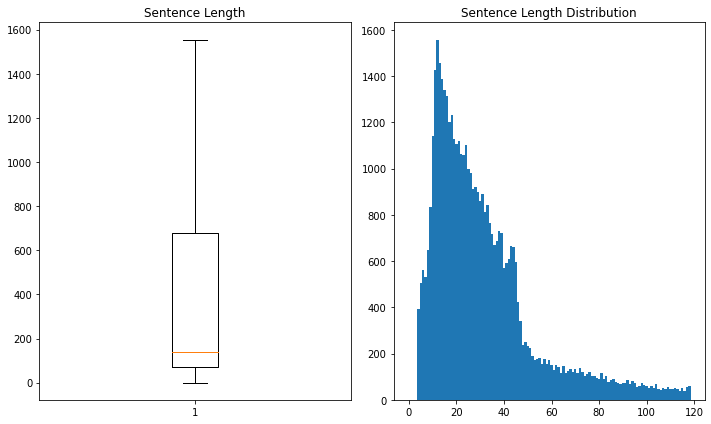

,document,label
0,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
1,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
2,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
3,"음악이 주가 된, 최고의 음악영화",1
4,진정한 쓰레기,0
...,...,...
46288,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
46289,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
46290,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
46291,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [24]:
#- test data preprocessing (max cleaned)
max_cleaned_test = min_cleaned_test.copy()
max_cleaned_test = max_cleaned_test[max_cleaned_test['document'].str.contains("[ㄱ-ㅎㅏ-ㅣ가-힣 ]")]


min_len = 5; max_len = 120
threshold_len(min_len, max_len, max_cleaned_test.document.astype(str))
max_cleaned_test = max_cleaned_test.iloc[[idx for idx,s in enumerate(max_cleaned_test.document) if (len(s) < max_len) & (len(s) >= min_len)]]
max_cleaned_test.reset_index(drop=True, inplace=True) 
sen_distribution(max_cleaned_test.document)
max_cleaned_test

Text(0.5, 1.0, 'max_cleaned_test')

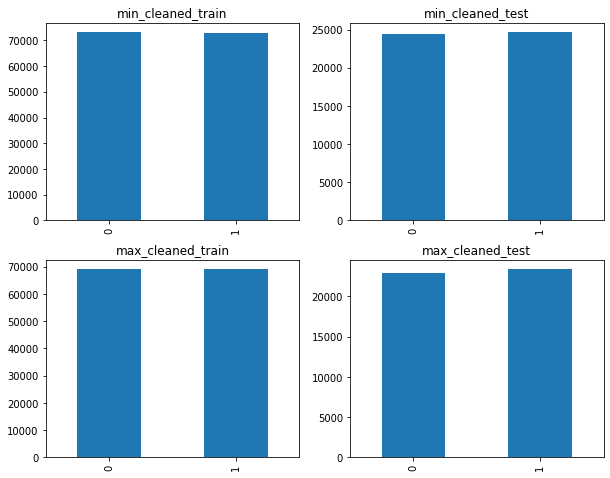

In [25]:
#- label 0, 1의 비율을 확인합니다.
fig, axes = plt.subplots(figsize=(10,8),nrows=2, ncols=2)

min_cleaned_train['label'].value_counts().plot(ax=axes[0,0], kind='bar');axes[0,0].set_title('min_cleaned_train')
min_cleaned_test['label'].value_counts().plot(ax=axes[0,1], kind='bar');axes[0,1].set_title('min_cleaned_test')
max_cleaned_train['label'].value_counts().plot(ax=axes[1,0], kind='bar');axes[1,0].set_title('max_cleaned_train')
max_cleaned_test['label'].value_counts().plot(ax=axes[1,1], kind='bar');axes[1,1].set_title('max_cleaned_test')
# print(min_cleaned_train.groupby('label').size().reset_index(name='count'))
# print(min_cleaned_test.groupby('label').size().reset_index(name='count'))

## 4. SentencePiece 학습
- input_data(min/max cleaned), model_type(unigram/bpe), vocap_size(8000/32000)에 따라 총 8가지 경우를 따로 학습시키고 성능을 비교분석해봅니다. 
- 변수 이름에는 sp_modeltype_vocabsize의 형식으로 구성했으며, input_data의 type에 따라 구분하여 학습을 진행했습니다. 

In [26]:
#- SentencePiece 설치

! pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [27]:
def df2list(df_train, df_test):
    train_pair = [(row[0], row[1]) for _, row in df_train.iterrows()]
    train_data = [pair[0] for pair in train_pair]
    #train_label = np.array([pair[1] for pair in train_pair])
    train_label = [pair[1] for pair in train_pair]

    test_pair = [(row[0], row[1]) for _, row in df_test.iterrows()]
    test_data = [pair[0] for pair in test_pair]
    #test_label = np.array([pair[1] for pair in test_pair])
    test_label = [pair[1] for pair in test_pair ]
    
    return train_data, train_label, test_data, test_label

In [28]:
train_data,train_label,test_data,test_label = df2list(df_train, df_test)
min_train_data,min_train_label,min_test_data,min_test_label = df2list(min_cleaned_train, min_cleaned_test)
max_train_data,max_train_label,max_test_data,max_test_label = df2list(max_cleaned_train, max_cleaned_test)

In [29]:
#- subword 학습을 위해 문장만 따로 저장합니다.
def saveTxt(train_data, option=''):
    '''
    option에는 데이터의 전처리 성격에 따라 
    공백(원본), 'min'(최소전처리), 'max'(최대전처리)) 값을 넣어줍니다.
    '''
    input_file = dir_path + option + 'train_tokenizer.txt'
    with open(input_file, 'w', encoding='utf-8') as f:
        for line in train_data:
            f.write(str(line)+'\n')

    with open(input_file, 'r', encoding='utf-8') as f:
        test_tokenizer = f.read().split('\n')
    
    return input_file, test_tokenizer 

In [30]:
input_file, test_tokenizer = saveTxt(train_data, option='')
min_input_file, _ = saveTxt(min_train_data, option='min')
max_input_file, _ = saveTxt(max_train_data, option='max')

num_word_list = [len(sentence.split()) for sentence in test_tokenizer]
print('\n코퍼스 평균/총 단어 갯수 : %.1f / %d' % (sum(num_word_list)/len(num_word_list), sum(num_word_list)))    


코퍼스 평균/총 단어 갯수 : 7.6 / 1137741


In [31]:
import sentencepiece as spm
import os

def sentencePiece(input_file, model_type='unigram', vocab_size=32000):
    
    #- SentencePiece 학습
    #input_file = dir_path+'train_tokenizer.txt'

    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root):
        os.mkdir(sp_model_root)
    model_type = model_type  # 학습할 모델 선택, unigram 또는 BPE
    sp_model_name = 'tokenizer_%s' % (model_type+str(vocab_size))
    sp_model_path = os.path.join(sp_model_root, sp_model_name)
    
    character_coverage  = 1.0  # 전체를 cover 하기 위해, default=0.9995
    user_defined_symbols = '[PAD],[UNK],[CLS],[SEP],[MASK],[BOS],[EOS],[UNK0],[UNK1],[UNK2],[UNK3],[UNK4],[UNK5],[UNK6],[UNK7],[UNK8],[UNK9],[unused0],[unused1],[unused2],[unused3],[unused4],[unused5],[unused6],[unused7],[unused8],[unused9],[unused10],[unused11],[unused12],[unused13],[unused14],[unused15],[unused16],[unused17],[unused18],[unused19],[unused20],[unused21],[unused22],[unused23],[unused24],[unused25],[unused26],[unused27],[unused28],[unused29],[unused30],[unused31],[unused32],[unused33],[unused34],[unused35],[unused36],[unused37],[unused38],[unused39],[unused40],[unused41],[unused42],[unused43],[unused44],[unused45],[unused46],[unused47],[unused48],[unused49],[unused50],[unused51],[unused52],[unused53],[unused54],[unused55],[unused56],[unused57],[unused58],[unused59],[unused60],[unused61],[unused62],[unused63],[unused64],[unused65],[unused66],[unused67],[unused68],[unused69],[unused70],[unused71],[unused72],[unused73],[unused74],[unused75],[unused76],[unused77],[unused78],[unused79],[unused80],[unused81],[unused82],[unused83],[unused84],[unused85],[unused86],[unused87],[unused88],[unused89],[unused90],[unused91],[unused92],[unused93],[unused94],[unused95],[unused96],[unused97],[unused98],[unused99]'

    input_argument = '--input=%s --model_prefix=%s --vocab_size=%s --user_defined_symbols=%s --model_type=%s --character_coverage=%s'
    cmd = input_argument%(input_file, sp_model_path, vocab_size,user_defined_symbols, model_type, character_coverage)

    spm.SentencePieceTrainer.Train(cmd)
    return sp_model_path

In [38]:
#- SentencePiece/min_cleaned/model_type=unigram/vocab=8000
sp_u_8_model_path = sentencePiece(min_input_file, model_type='unigram', vocab_size=8000)
sp_u_8 = spm.SentencePieceProcessor()
sp_u_8.Load('{}.model'.format(sp_u_8_model_path)) 

#- SentencePiece/min_cleaned/model_type=unigram/vocab=32000
sp_u_32_model_path = sentencePiece(min_input_file, model_type='unigram', vocab_size=32000)
sp_u_32 = spm.SentencePieceProcessor()
sp_u_32.Load('{}.model'.format(sp_u_32_model_path)) 

#- SentencePiece/min_cleaned/model_type=BPE/vocab=8000
sp_b_8_model_path = sentencePiece(min_input_file, model_type='BPE', vocab_size=8000)
sp_b_8 = spm.SentencePieceProcessor()
sp_b_8.Load('{}.model'.format(sp_b_8_model_path)) 

# SentencePiece/min_cleaned/model_type=BPE/vocab=32000
sp_b_32_model_path = sentencePiece(min_input_file, model_type='BPE', vocab_size=32000)
sp_b_32 = spm.SentencePieceProcessor()
sp_b_32.Load('{}.model'.format(sp_b_32_model_path)) 

True

In [33]:
# #- SentencePiece/max_cleaned/model_type=unigram/vocab=8000
# sp_u_8_model_path = sentencePiece(max_input_file, model_type='unigram', vocab_size=8000)
# sp_u_8 = spm.SentencePieceProcessor()
# sp_u_8.Load('{}.model'.format(sp_u_8_model_path)) 

# #- SentencePiece/max_cleaned/model_type=unigram/vocab=32000
# sp_u_32_model_path = sentencePiece(max_input_file, model_type='unigram', vocab_size=32000)
# sp_u_32 = spm.SentencePieceProcessor()
# sp_u_32.Load('{}.model'.format(sp_u_32_model_path)) 

# #- SentencePiece/max_cleaned/model_type=BPE/vocab=8000
# sp_b_8_model_path = sentencePiece(max_input_file, model_type='BPE', vocab_size=8000)
# sp_b_8 = spm.SentencePieceProcessor()
# sp_b_8.Load('{}.model'.format(sp_b_8_model_path)) 

# #- SentencePiece/max_cleaned/model_type=BPE/vocab=32000
# sp_b_32_model_path = sentencePiece(max_input_file, model_type='BPE', vocab_size=32000)
# sp_b_32 = spm.SentencePieceProcessor()
# sp_b_32.Load('{}.model'.format(sp_b_32_model_path)) 

In [34]:
#- 영화리뷰 글
test_txts_0 = ['언니동생친구사촌팔촌까지다보여주고싶은인생영화!!!꼭보세요강추입니다.', 'ㅜㅜ내12000원...', '음..너무감동을 짜내는것같아서 아쉽', '100점만점에100점드립니다^^','역시혜수언니..너무멋있어 언니♥♥해','이게 공포..?ㅋ','너무슬퍼서 엉엉울면서봤어요 ㅠ_ㅠ 다행히 저만 우는건 아니었네여 여기저기서 훌쩍','한국최고의SF입니다.역사를새로썼네요']
#- 일상 글
test_txts_1 = ['나는 오늘 아침에 찰옥수수와 밤고구마를 먹었다.','오늘날씨가너무조아','이모! 여기 야채주먹밥 하나요~ 맨밥에 싸주세요ㅎㅎㅎㅎ감사합니다', '국화꽃향기','살랑살랑 불어오는 봄바람','나에겐 니가 이 세상에서 쵝오야~']

In [35]:
def testSP(sp, txts):
    tokens_list = []
    for txt in txts:
        tokens = sp.encode_as_pieces(txt)
        #ids = sp.encode_as_ids(txt)
        tokens_list.append(tokens)
    return tokens_list

In [39]:
txts = test_txts_0 + test_txts_1
tokens_u_8 = testSP(sp_u_8, txts)
tokens_u_32 = testSP(sp_u_32, txts)
tokens_b_8 = testSP(sp_b_8, txts)
tokens_b_32 = testSP(sp_b_32, txts)

In [40]:
compare_tokenizer_8 = pd.DataFrame(data = list(zip(txts, tokens_u_8, tokens_b_8)),columns=['Original','Unigram','BPE'])
compare_tokenizer_8

,Original,Unigram,BPE
0,언니동생친구사촌팔촌까지다보여주고싶은인생영화!!!꼭보세요강추입니다.,"[▁, 언니, 동생, 친구, 사, 촌, 팔, 촌, 까지, 다, 보여주, 고싶은, 인...","[▁언, 니, 동생, 친구, 사, 촌, 팔, 촌, 까지, 다, 보여, 주고, 싶은,..."
1,ㅜㅜ내12000원...,"[▁ᅮᅮ, 내, 1, 20, 00, 원, ...]","[▁ᅮᅮ, 내, 12, 000, 원, ...]"
2,음..너무감동을 짜내는것같아서 아쉽,"[▁음, .., 너무, 감동, 을, ▁짜, 내는, 것같아, 서, ▁아쉽]","[▁음, .., 너무, 감동, 을, ▁짜, 내는, 것같, 아서, ▁아쉽]"
3,100점만점에100점드립니다^^,"[▁100, 점, 만, 점, 에, 100, 점, 드립니다, ^^]","[▁100, 점만점, 에, 100, 점, 드립니다, ^^]"
4,역시혜수언니..너무멋있어 언니♥♥해,"[▁역시, 혜, 수, 언니, .., 너무, 멋있, 어, ▁, 언니, ♥♥, 해]","[▁역시, 혜, 수, 언니, .., 너무, 멋, 있어, ▁언, 니, ♥♥, 해]"
5,이게 공포..?ㅋ,"[▁이게, ▁공포, .., ?, ᄏ]","[▁이게, ▁공포, ..?, ᄏ]"
6,너무슬퍼서 엉엉울면서봤어요 ㅠ_ㅠ 다행히 저만 우는건 아니었네여 여기저기서 훌쩍,"[▁너무, 슬, 퍼, 서, ▁, 엉, 엉, 울, 면서, 봤, 어요, ▁ᅲ, _, ᅲ...","[▁너무, 슬, 퍼, 서, ▁엉, 엉, 울, 면서, 봤어요, ▁ᅲ, _, ᅲ, ▁다..."
7,한국최고의SF입니다.역사를새로썼네요,"[▁한국, 최고의, S, F, 입니다, ., 역사, 를, 새, 로, 썼, 네요]","[▁한국, 최고의, S, F, 입니다, ., 역, 사를, 새, 로, 썼, 네요]"
8,나는 오늘 아침에 찰옥수수와 밤고구마를 먹었다.,"[▁나는, ▁오늘, ▁아침, 에, ▁찰, 옥, 수, 수, 와, ▁밤, 고, 구, 마...","[▁나는, ▁오늘, ▁아침, 에, ▁찰, 옥, 수, 수, 와, ▁밤, 고, 구, 마..."
9,오늘날씨가너무조아,"[▁오늘, 날, 씨가, 너무, 조, 아]","[▁오늘, 날, 씨가, 너무, 조, 아]"


- 단어장의 크기가 8000개인 경우, unigram 및 BPE 모두 {밤고구마 : ▁밤, 고, 구, 마. , 날씨가 : 날,씨가} 와 같이 단어의 의미단위로 토큰화가 미흡해보입니다. 
- unigram의 경우 {'봄바람' : '봄','바람' , '역사를':'역사','를' ,'언니':'언니'}  bpe의 경우 {'봄바람' : '봄','바','람' , '역사를':'역','사','를' ,'언니':'언','니'} 로 토큰화한 결과로 보아, unigram의 성능이 조금 더 나은 것 같습니다. 

In [41]:
compare_tokenizer_32 = pd.DataFrame(data = list(zip(txts, tokens_u_32, tokens_b_32)),columns=['Original','Unigram','BPE'])
compare_tokenizer_32

,Original,Unigram,BPE
0,언니동생친구사촌팔촌까지다보여주고싶은인생영화!!!꼭보세요강추입니다.,"[▁언니, 동생, 친구, 사촌, 팔, 촌, 까지, 다, 보여주고싶은, 인생, 영화,...","[▁언니, 동생, 친구, 사, 촌, 팔, 촌, 까지, 다, 보여, 주고싶은, 인생,..."
1,ㅜㅜ내12000원...,"[▁ᅮᅮ, 내, 1, 2000, 원, ...]","[▁ᅮᅮ, 내, 12, 000, 원, ...]"
2,음..너무감동을 짜내는것같아서 아쉽,"[▁음, .., 너무, 감동을, ▁짜내, 는, 것같아서, ▁아쉽]","[▁음, .., 너무, 감동을, ▁짜, 내는, 것같아서, ▁아쉽]"
3,100점만점에100점드립니다^^,"[▁100, 점만점에, 100, 점드립니다, ^^]","[▁100, 점만점에, 100, 점드립니다, ^^]"
4,역시혜수언니..너무멋있어 언니♥♥해,"[▁역시, 혜, 수, 언니, .., 너무, 멋있, 어, ▁언니, ♥♥, 해]","[▁역시, 혜, 수, 언니, .., 너무, 멋, 있어, ▁언니, ♥♥, 해]"
5,이게 공포..?ㅋ,"[▁이게, ▁공포, .., ?, ᄏ]","[▁이게, ▁공포, ..?, ᄏ]"
6,너무슬퍼서 엉엉울면서봤어요 ㅠ_ㅠ 다행히 저만 우는건 아니었네여 여기저기서 훌쩍,"[▁너무, 슬퍼, 서, ▁엉엉, 울면서, 봤어요, ▁ᅲ, _, ᅲ, ▁다행히, ▁저...","[▁너무, 슬퍼, 서, ▁엉엉, 울면서, 봤어요, ▁ᅲ, _, ᅲ, ▁다행히, ▁저..."
7,한국최고의SF입니다.역사를새로썼네요,"[▁한국, 최고의, SF, 입니다, ., 역사, 를, 새, 로, 썼, 네요]","[▁한국, 최고의, SF, 입니다, ., 역, 사를, 새, 로, 썼, 네요]"
8,나는 오늘 아침에 찰옥수수와 밤고구마를 먹었다.,"[▁나는, ▁오늘, ▁아침에, ▁찰, 옥, 수, 수, 와, ▁밤, 고구마, 를, ▁...","[▁나는, ▁오늘, ▁아침에, ▁찰, 옥, 수, 수와, ▁밤, 고, 구, 마를, ▁..."
9,오늘날씨가너무조아,"[▁오늘날, 씨가, 너무, 조아]","[▁오늘날, 씨가, 너무, 조아]"


- 0번 문장에서 unigram의 경우 vocabsize 8000일 때는 {'사촌': '사','촌' , '엉엉울면서':'엉','엉','울','면서' , '밤고구마' : '밤','고','구','마' , '국화꽃향기' : '국','화','꽃','향','기'}였는데 vocabsize=32000의 경우 {'사촌': '사촌' , '엉엉울면서':'엉엉','울면서' , '밤고구마' : '밤','고구마' , '국화꽃향기' : '국','화','꽃','향기'} 입니다. 
- bpe의 경우도 마찬가지로 {'언니':'언니', '봄바람':'봄''바람'}과 같이 vocabsize 8000인 경우보다 나아졌지만, 여전히 unigram이 조금 더 성능이 나아보입니다. 

## 4-2. 학습된 모델로 sp_tokenize() 메소드를 구현

#### 코드 살펴보기
- tokenizer_32000.vocab의 구성은 아래와 같습니다.
- sp_tokenize 함수에서 word = line.split("\t")[0] 의 이유가 여기에 있습니다 ~ 


```
.	-3.26527
▁	-3.7578
..	-4.20228
...	-4.45332
▁영화	-4.4884
,	-4.72582
의	-4.73467
이	-4.89003
도	-4.94832
는	-4.97102
가	-4.98213
을	-5.12609
?	-5.13675
에	-5.33163
```

In [42]:
#- Tokenizer 함수
def sp_tokenize(sp, model_path, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(sp.EncodeAsIds(sen)) #- s.EncodeAsIds() : sentence -> encoding
    with open('{}.vocab'.format(model_path)) as f:
        vocab = f.readlines() #- spm 학습 단어사전 
    
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0] #- vocab파일에서 단어(형태소)만 저장합니다.
        
        word_index.update({idx:word})
        index_word.update({word:idx})
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') 
    return tensor, word_index, index_word

In [43]:
tensor, word_index, index_word = sp_tokenize(sp_u_32,sp_u_32_model_path, test_txts_1)
print(tensor)

[[  437   655  8033  8608  3809   252   252   165  2883 29298   139  8482
    140   120     0     0     0     0]
 [12812  2225   311  7655     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  141   763   136  1154  1140  1634 16821  3250   290   182   143  2777
   3250   133  3574  2646  7007  8786]
 [ 3748   460  6295 18206     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [ 1203   242   587   242 15517  4002  1066  4804     0     0     0     0
      0     0     0     0     0     0]
 [ 3855  5819   141  5404  2460   218   143     0     0     0     0     0
      0     0     0     0     0     0]]


## 4-3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델 재학습
- BiLSTM을 활용하여 학습시키겠습니다.

In [44]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.models import load_model
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
def trainBiLSTM(x_train, y_train, x_test, y_test, word_index, word_vector_dim = 150, epochs=15, batch_size=32):
    '''
    word_vector_dim은 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
    '''
    vocab_size = len(word_index) #- 어휘 사전의 크기
    partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)
    
    #- Bidirectional LSTM
    model_blstm = keras.Sequential()
    model_blstm.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model_blstm.add(Dropout(0.5))
    model_blstm.add(LSTM(256, return_sequences=True))
    model_blstm.add(Dropout(0.5))
    model_blstm.add(Bidirectional(LSTM(256, return_sequences=True)))
    model_blstm.add(Dropout(0.5))
    model_blstm.add(Dense(1, activation='sigmoid'))

    model_blstm.summary()
    
    #- Compile
    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
    mc = ModelCheckpoint(dir_path+'best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)                  
    model_blstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    
    #- Train
    history_blstm = model_blstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, mc],
                    verbose=1)
    
    blstm_loss, blstm_acc = model_blstm.evaluate(x_test, y_test, verbose=2)
    print("Test Loss: %.4f\nTest_Accuracy: %.4f" % (blstm_loss, blstm_acc))

    
    return history_blstm 

def plot_history(history_blstm):
    
    history_dict = history_blstm.history
    train_acc = history_dict['accuracy']
    train_loss = history_dict['loss']
    val_acc = history_dict['val_accuracy']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, train_acc)
    plt.plot(epochs, val_loss)
    plt.plot(epochs, val_acc)
    plt.legend(['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'],loc='center right')
    plt.show()

def sentiment_predict_sp(sp, model_path, sentences):

    new_sentence,_,index = sp_tokenize(sp, model_path, sentences) # 토큰화
    print(new_sentence)
  
    loaded_model = load_model(dir_path+'best_model.h5')
    print("Test Loss: %.4f\nTest_Accuracy: %.4f" % (loaded_model.evaluate(x_test, y_test)[0],loaded_model.evaluate(x_test, y_test)[1]))

    for i, sen in enumerate(new_sentence):
        score = loaded_model.predict(sen).mean() # 예측
        
        print(sentences[i])
        if(score > 0.5):
            print("{:.2f}% 긍정\n".format(score * 100))
        else:
            print("{:.2f}% 부정\n".format((1 - score) * 100))

In [46]:
x_train, word_index, index_word = sp_tokenize(sp_u_32, sp_u_32_model_path,  min_train_data)
x_test, _, _ = sp_tokenize(sp_u_32, sp_u_32_model_path,  map(str,min_test_data))
y_train = np.array(min_train_label)
y_test = np.array(min_test_label)
sp_u_32_history_blstm = trainBiLSTM(x_train, y_train, x_test, y_test, word_index, word_vector_dim = 150, epochs=15, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 150)         4800000   
_________________________________________________________________
dropout (Dropout)            (None, None, 150)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 256)         416768    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         1050624   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           5

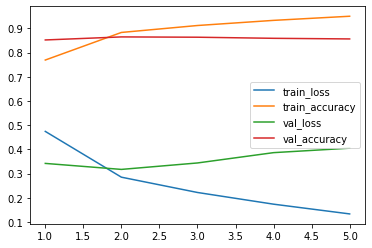

In [47]:
plot_history(sp_u_32_history_blstm)

In [48]:
sentiment_predict_sp(sp_u_32,sp_u_32_model_path, test_txts_0)

[[ 4942  6878  3119 28249  3484  9591   233   140 29696  2599   156   212
  12477  1525   343   120     0     0]
 [  779   350   260 20406   509   123     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  902   122   311 10863 11657   129 10395  3840     0     0     0     0
      0     0     0     0     0     0]
 [ 1170  5170  4832  9699   226     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  229  3581   252  2510   122   311  9880   210  4942  2219   208     0
      0     0     0     0     0     0]
 [  214   603   122   132   227     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [  134 11958   179  9050 22693  3583   565  1290   306 20880 15366  5330
    249   430  8106   280 22229 15812]
 [  371  2485 12474   343   120  5602   139  1633   146  7425   223     0
      0     0     0     0     0     0]]
1536/1536 [==============================] - 59s 38ms/step - loss: 0.3199 - accuracy: 0.8625
Te

# 5. KoNLPy 형태소 분석기를 사용한 모델과 성능을 비교
- KoNLPy 형태소 분석기 중에서 학습 정확도/속도 면에서 효율이 좋은 Mecab을 사용합니다. 
- 최대 전처리 데이터 및 최소 전처리 데이터로 학습한 경우를 비교분석합니다. 


In [49]:
from konlpy.tag import Mecab
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
mecab = Mecab()

kor_text = test_txts_1

for text in kor_text:
    print('[{}] \n{}'.format(mecab.__class__.__name__, mecab.pos(text)))

[Mecab] 
[('나', 'NP'), ('는', 'JX'), ('오늘', 'MAG'), ('아침', 'NNG'), ('에', 'JKB'), ('찰옥수수', 'NNG'), ('와', 'JC'), ('밤고구마', 'NNG'), ('를', 'JKO'), ('먹', 'VV'), ('었', 'EP'), ('다', 'EF'), ('.', 'SF')]
[Mecab] 
[('오늘', 'MAG'), ('날씨', 'NNG'), ('가', 'JKS'), ('너무', 'MAG'), ('조아', 'NNG')]
[Mecab] 
[('이모', 'NNG'), ('!', 'SF'), ('여기', 'NP'), ('야채', 'NNG'), ('주먹밥', 'NNG'), ('하나', 'NR'), ('요', 'VCP+EC'), ('~', 'SY'), ('맨밥', 'NNG'), ('에', 'JKB'), ('싸', 'VV+EC'), ('주', 'VX'), ('세요', 'EP+EF'), ('ㅎㅎ', 'IC'), ('ㅎㅎ', 'IC'), ('감사', 'NNG'), ('합니다', 'XSV+EC')]
[Mecab] 
[('국화꽃', 'NNG'), ('향기', 'NNG')]
[Mecab] 
[('살랑살랑', 'MAG'), ('불어오', 'VV'), ('는', 'ETM'), ('봄바람', 'NNG')]
[Mecab] 
[('나', 'NP'), ('에겐', 'JKB+JX'), ('니', 'NP'), ('가', 'JKS'), ('이', 'MM'), ('세상', 'NNG'), ('에서', 'JKB'), ('쵝오야', 'UNKNOWN'), ('~', 'SY')]


- 역시 형태소분석기는 한글을 제대로 배운 티가 납니다. 정말 깔끔하게 문장을 형태소단위로 토큰화하고 있습니다.

In [51]:
def tokenize(train_data, test_data):
   
    x_train = []
    for sentence in train_data:
        temp_x = mecab.morphs(sentence)
        temp_x = [word for word in temp_x if not word in stopwords]
        x_train.append(temp_x)
        
    x_test = []
    for sentence in test_data:
        temp_x = mecab.morphs(sentence) 
        temp_x = [word for word in temp_x if not word in stopwords] 
        x_test.append(temp_x)
    
    return x_train, x_test


def padding(x_train, x_test):    
  
    x_train = pad_sequences(x_train, padding='pre') # 혹은 'post'
    x_test = pad_sequences(x_test, padding='pre') # 혹은 'post'
            
    return x_train, x_test

### max_train_data(최대 전처리)로 Mecab 학습

In [52]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
x_train, x_test = tokenize(max_train_data, max_test_data)

In [53]:
vocab_size = 32000
#- encoding
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
#- label
y_train = np.array(max_train_label)
y_test = np.array(max_test_label)
#- padding
x_train, x_test = padding(x_train, x_test)

In [54]:
mecab_32_history_blstm = trainBiLSTM(x_train, y_train, x_test, y_test, word_index, word_vector_dim = 150, epochs=15, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 150)         4800000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 150)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 256)         416768    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1050624   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)          

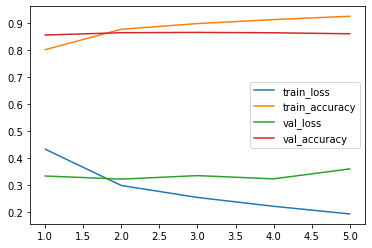

In [55]:
plot_history(mecab_32_history_blstm)

In [56]:
loaded_model = load_model(dir_path+'best_model.h5')
print("Test Loss: %.4f\nTest_Accuracy: %.4f" % (loaded_model.evaluate(x_test, y_test)[0],loaded_model.evaluate(x_test, y_test)[1]))


1447/1447 [==============================] - 29s 20ms/step - loss: 0.3384 - accuracy: 0.8633
Test Loss: 0.3384
Test_Accuracy: 0.8633


In [70]:
def sentiment_predict(new_sentences):
    for i, new_sentence in enumerate(new_sentences):
        new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
        new_sentence = mecab.morphs(new_sentence) # 토큰화
        new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
        encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
        pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
        
    
        score = loaded_model.predict(pad_new).mean() # 예측
        #print(score)
        print(new_sentences[i])
        if(score > 0.5):
            print("{:.2f}% 긍정\n".format(score * 100))
        else:
            print("{:.2f}% 부정\n".format((1 - score) * 100))

In [58]:
sentiment_predict(test_txts_0)

0.99174094
언니동생친구사촌팔촌까지다보여주고싶은인생영화!!!꼭보세요강추입니다.
99.17% 긍정

0.42493883
ㅜㅜ내12000원...
57.51% 부정

0.34656006
음..너무감동을 짜내는것같아서 아쉽
65.34% 부정

0.31510925
100점만점에100점드립니다^^
68.49% 부정

0.9840258
역시혜수언니..너무멋있어 언니♥♥해
98.40% 긍정

0.1952955
이게 공포..?ㅋ
80.47% 부정

0.9914332
너무슬퍼서 엉엉울면서봤어요 ㅠ_ㅠ 다행히 저만 우는건 아니었네여 여기저기서 훌쩍
99.14% 긍정

0.98611045
한국최고의SF입니다.역사를새로썼네요
98.61% 긍정



In [63]:
test_txts_2 = ['넘 재밌어!','짜증나','내가 제일 좋아하는 영화','추천합니다','이걸 왜 봐..','최악의 영화입니다','절대 보지 마세요','화가난다ㅡㅡ']
sentiment_predict(test_txts_2)

0.98062897
넘 재밌어!
98.06% 긍정

0.014498449
짜증나
98.55% 부정

0.9384223
내가 제일 좋아하는 영화
93.84% 긍정

0.88156337
추천합니다
88.16% 긍정

0.08895704
이걸 왜 봐..
91.10% 부정

0.0035874457
최악의 영화입니다
99.64% 부정

0.07740569
절대 보지 마세요
92.26% 부정

0.01701341
화가난다ㅡㅡ
98.30% 부정



### min_train_data(최소 전처리)로 Mecab 학습

In [64]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
x_train, x_test = tokenize(min_train_data, min_test_data)

In [65]:
vocab_size = 32000
#- encoding
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
#- label
y_train = np.array(min_train_label)
y_test = np.array(min_test_label)
#- padding
x_train, x_test = padding(x_train, x_test)

In [66]:
mecab_32_history_blstm = trainBiLSTM(x_train, y_train, x_test, y_test, word_index, word_vector_dim = 150, epochs=15, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 150)         4800000   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 150)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 256)         416768    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 512)         1050624   
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)          

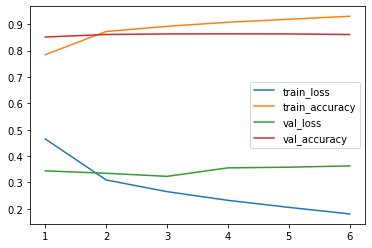

In [67]:
plot_history(mecab_32_history_blstm)

In [68]:
loaded_model = load_model(dir_path+'best_model.h5')
print("Test Loss: %.4f\nTest_Accuracy: %.4f" % (loaded_model.evaluate(x_test, y_test)[0],loaded_model.evaluate(x_test, y_test)[1]))

1536/1536 [==============================] - 48s 31ms/step - loss: 0.3560 - accuracy: 0.8629
Test Loss: 0.3560
Test_Accuracy: 0.8629


In [71]:
sentiment_predict(test_txts_0)

언니동생친구사촌팔촌까지다보여주고싶은인생영화!!!꼭보세요강추입니다.
99.57% 긍정

ㅜㅜ내12000원...
51.16% 부정

음..너무감동을 짜내는것같아서 아쉽
55.07% 부정

100점만점에100점드립니다^^
82.35% 긍정

역시혜수언니..너무멋있어 언니♥♥해
98.98% 긍정

이게 공포..?ㅋ
53.10% 부정

너무슬퍼서 엉엉울면서봤어요 ㅠ_ㅠ 다행히 저만 우는건 아니었네여 여기저기서 훌쩍
99.66% 긍정

한국최고의SF입니다.역사를새로썼네요
99.56% 긍정



# 6. SentencePiece 모델의 model_type, vocab_size 등을 변경하면서 성능 개선 여부를 확인

- min_cleaned_train(최소한의 전처리)는 중복값 제거, 결측치 제거, check_only_number 제거 를 적용했으며,
- max_cleaned_train(최대한의 전처리)는 중복값 제거, 결측치 제거, check_only_number 제거에 더하여 한글과 공백이외에 모두 제거, 불용어 제거, 문장길이 제한 을 적용했습니다. 
- 아래 표에서 변수명은 dataType(min/max)_sp_modelType(unigram/bpe)_vocabsize(8000/32000) 로 구성됩니다. (dataType은 biLSTM input data의 Type입니다.)
- 아래 표는 각 옵션에 따른 SentencePiece의 성능을 정리한 것입니다. 성능평가 지표로는 Test Loss/Accuracy(정량) 및 리뷰예측(정성)을 사용합니다.
- 아래 리뷰예측에서 굵은 표시가 된것은 잘못된 예측입니다.

### min_cleaned_data로(최소 전처리 데이터)로 sentencepiece 모델 학습


||min_sp_u_32|max_sp_u_32|min_sp_b_32|max_sp_b_32|min_sp_u_8|max_sp_u_8|min_sp_b_8|max_sp_b_8|
|--|--|--|--|--|--|--|--|--|
|언니동생친구사촌팔촌까지다보여주고싶은인생영화!!!꼭보세요강추입니다.|58.54%  긍정 |54.41%  긍정 |65.02% 긍정 |56.33% 긍정 |51.39%  긍정 |53.00%  긍정 |54.68%  긍정 |**50.89%  부정**|
|음..너무감동을 짜내는것같아서 아쉽|56.41%  부정 |52.08%  부정 |52.42% 부정 |52.40% 부정 |56.08%  부정 |51.10%  부정 |**50.73%  긍정**|56.43%  부정 |
|ㅜㅜ내12000원...|59.83%  부정 |54.08%  부정 |55.34% 부정 |55.70% 부정 |58.06%  부정 |51.96%  부정 |51.76%  부정 |60.65%  부정 |
|역시혜수언니..너무멋있어 언니♥♥해|50.63%  긍정 |56.01%  긍정 |59.53% 긍정 |53.32% 긍정 |**52.21%  부정**|53.18%  긍정 |54.89%  긍정 |**51.82%  부정**|
|**100점만점에100점드립니다^^**|**50.21%  부정**|50.96%  긍정 |55.60% 긍정 |52.54% 긍정 |**55.69%  부정**|**51.97%  부정**|54.21%  긍정 |**55.29%  부정**|
|이게 공포..?ㅋ|60.51%  부정 |54.55%  부정 |54.05% 부정 |54.64% 부정 |59.33%  부정 |54.06%  부정 |**50.45%  긍정**|58.95%  부정 |
|**너무슬퍼서 엉엉울면서봤어요 ㅠ_ㅠ 다행히 저만 우는건 아니었네여 여기저기서 훌쩍**|58.71%  긍정 |57.09%  긍정 |63.99% 긍정 |57.83% 긍정 |**50.88%  부정**|**51.35%  부정**|**52.25%  부정**|**52.61%  부정**|
|**한국최고의SF입니다.역사를새로썼네요**|**50.91%  부정**|**50.49%  부정**|52.57% 긍정 |51.99% 긍정 |**53.41%  부정**|50.03%  긍정 |54.89%  긍정 |**55.04%  부정**|
|정답률|6/8|7/8|8/8|8/8|4/8|6/8|6/8|3/8|
|Tokenizer|SP_unigram|SP_unigram|SP_BPE|SP_BPE|SP_unigram|SP_unigram|SP_BPE|SP_BPE|
|SP Input|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|
|BiLSTM Input|min_cleaned|max_cleaned|min_cleaned|max_cleaned|min_cleaned|max_cleaned|min_cleaned|max_cleaned|
|vocab size|32000|32000|32000|32000|8000|8000|8000|8000|
|Test Loss|0.3785|0.4220|0.4123|0.4783|0.3721|0.3531|0.3526|0.3411|
|Test Accuracy|0.8577|0.8517|0.8521|0.8522|0.8574|0.8581|0.8537|0.8590|


### min_cleaned_data로(최대 전처리 데이터)로 sentencepiece 모델 학습

||min_sp_u_32|max_sp_u_32|min_sp_b_32|max_sp_b_32|min_sp_u_8|max_sp_u_8|min_sp_b_8|max_sp_b_8|
|--|--|--|--|--|--|--|--|--|
|언니동생친구사촌팔촌까지다보여주고싶은인생영화!!!꼭보세요강추입니다.|59.58% 긍정|59.46% 긍정|58.68% 긍정|55.90% 긍정|57.42% 긍정|55.47% 긍정|50.73% 긍정|50.04% 긍정|
|음..너무감동을 짜내는것같아서 아쉽|**52.26% 긍정**|52.46% 부정|51.33% 부정|53.89% 부정|**50.57% 긍정**|**51.33% 긍정**|53.80% 부정|55.91% 부정|
|ㅜㅜ내12000원...|50.07% 부정|56.49% 부정|54.46% 부정|57.92% 부정|51.70% 부정|50.04% 부정|56.56% 부정|59.70% 부정|
|역시혜수언니..너무멋있어 언니♥♥해|58.58% 긍정|56.54% 긍정|56.09% 긍정|55.03% 긍정|56.65% 긍정|55.64% 긍정|**50.69% 부정**|**50.73% 부정**|
|**100점만점에100점드립니다^^**|57.43% 긍정|51.19% 긍정|54.48% 긍정|**50.30% 부정**|52.87% 긍정|54.10% 긍정|**52.70% 부정**|**55.48% 부정**|
|이게 공포..?ㅋ|52.24% 부정|57.24% 부정|53.22% 부정|56.05% 부정|50.06% 부정|51.49% 부정|56.09% 부정|59.47% 부정|
|**너무슬퍼서 엉엉울면서봤어요 ㅠ_ㅠ 다행히 저만 우는건 아니었네여 여기저기서 훌쩍**|60.86% 긍정|61.66% 긍정|60.87% 긍정|60.09% 긍정|**52.00% 부정**|50.14% 긍정|**50.06% 부정**|51.56% 긍정|
|**한국최고의SF입니다.역사를새로썼네요**|53.38% 긍정|**50.27% 부정**|**52.88% 부정**|**51.18% 부정**|51.82% 긍정|51.94% 긍정|**50.85% 부정**|**53.60% 부정**|
|정답률|7/8|7/8|7/8|6/8|6/8|7/8|4/8|5/8|
|Tokenizer|SP_unigram|SP_unigram|SP_BPE|SP_BPE|SP_unigram|SP_unigram|SP_BPE|SP_BPE|
|SP Input|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|min_cleaned|
|BiLSTM Input|min_cleaned|max_cleaned|min_cleaned|max_cleaned|min_cleaned|max_cleaned|min_cleaned|max_cleaned|
|vocab size|32000|32000|32000|32000|8000|8000|8000|8000|
|Test Loss|0.3894|0.4759|0.4219|0.4931|0.3391|0.3508|0.3383|0.3635|
|Test Accuracy|0.8546|0.8523|0.8546|0.8461|0.8592|0.8564|0.8581|0.8590|


# 7. 결과 분석
### SentencePiece
- SentencePiece의 옵션에 따른 성능비교분석을 위해 딥러닝 학습 모델은 BiLSTM 으로 통일했다.
- 처음에는 KoLNPy에는 SP 보다 조금 더 정제된 데이터를 넣어야 한다는 생각에 각 모델에 입력하기 위한 min/max cleaned data를 구분했다.
    - KoLNPy는 미리 학습된(등록된) 형태소를 기반으로 tokenizer를 생성하기 때문에, 한글을 제외한 숫자 또는 특수문자가 큰 노이즈로 작용할 수 있다고 판단했다.
    - 형태소분석기는 한글에 특화된 모델로, 우수한 성능을 보이지만 실제로는 SentencePiece가 주로 사용되는 이유중 하나가 미등록어 처리라고 한다.
- 데이터 전처리에 따른 Tokenizer의 성능 차이가 궁금해서 결국 실험을 했다.
- sentencepiece와 Bi-LSTM 학습에는 동일한 데이터를 사용할 계획이었으나, 실수로 min/max를 세분화해서 학습을 시켰고.. 결국 오랫동안 돌렸다(2x2x2x2=16개의 경우 발생)
- 성능평가 지표로는 Test Loss/Accuracy(정량) 및 직접 리뷰예측(정성)을 평가했다. 
- 정량평가는 accuracy 85-86%, loss 0.3-0.4% 로 옵션에 따른 차이가 크지 않았다. 
- unigram이 BPE 보다 loss/accuracy 지표가 (조금) 높은 것을 확인할 수 있다. 
- 정성평가는 실제 리뷰데이터를 참고하여 틀린맞춤법, 숫자, 특수문자, 영어 등을 포함하여 구성한 8개의 문장으로 진행했다.   
- unigram/bpe 모두 vocab size 8000보다 32000인 경우 정성평가 결과가 좋다. 역시 참고할 수 있는 단어가 많은 게 좋은 것 같다. 
- 최소 전처리이면서 단어장 개수가 32000인 BPE가 리뷰예측 퀴즈를 가장 잘 맞췄고 (만점~) 전반적으로 unigram이 높은 점수를 맞았다. 
- 그런데, 긍정/부정 예측 확률이 왜 죄다 50~60 사이(턱걸이)인지 원인을 찾지 못했다. 왜일까..? (이 결과를 믿을 수 있는 것인지 의문이다..ㅜ)    

    
### SP v. KoLNPy
- 확실히 SentencePiece KoLNPy와 비교했을 때 학습 속도가 빠르고, 효율 대비 성능이 좋다는 것을 확인했다.
- Okt 형태소 분석기로 진행했을 때 시간이 너무 오래 걸려서, 형태소 분석기중 가장 효율이 높은 mecab으로 진행했다.
- KoLNPy는 학습 속도도 느리고(mecab 제외) 전처리도 더욱 신경써야 하지만, 성능은 정말 좋은 것 같다. 
- 토큰화만 봐도.. 게임이 끝났다. KoLPy는 한글을 배운자다. 정말 깔~끔하게 토큰화를 할줄 안다. 
- 정량평가에서도 accuracy 86%, loss 35%로 SentencePiece 보다 좋은 성능을 보인다.
- 정성평가에서도 max_cleaned 데이터로 학습한 경우, '100점만점에100점^^'을 부정으로 예측한 것 이외에는 모두 정답을 맞췄다.  
- KoLNPy는 '중복값 제거, 결측치 제거, check_only_number 제거'만 진행한 min_cleaned_train(최소한의 전처리)보다 '한글과 공백이외에 모두 제거, 불용어 제거, 문장길이 제한'까지 적용한 max_cleaned_train(최대한의 전처리)로 학습했을 때 더 좋은 성능이 나올 것이라 예상했지만, min_cleaned_train으로 학습했을 때 '100점만점에100점^^'를 긍정으로 맞췄다. 숫자가 섞인 문장을 학습했는지의 차이인 것 같다. 무조건 한글과 공백으로만 구성된 깨끗한 데이터가 장땡은 아니라는 것을 확인할 수 있다. 
- SentencePiece보다 KoLNPY의 Mecab이 더 리뷰예측 정답률이 높을 뿐더러, 높은 확률로 정답을 예측했다. 



# 후기

- 직접 이렇게 실험을 해본것은 처음인데, 직접 비교해보니 확실히 차이가 있었고 재밌었다(힘들었다)
- 메모리 문제 때문에 형태소 분석기 학습이 자꾸 다운되서 애를 많이 먹었다..
- 실험을 해야해서 변수명을 달리해야 하는데, 변수명 설정에 많은 고민을 하게 된 것 같다. 
- 최대한 함수를 만들어서 실험을 진행했다. 클래스 만드는 건 아직 어렵다
- 의미가 있는 삽질이었기를 바란다

|평가문항|상세기준|
|--|--|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|